In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


In [3]:
import os

# Make sure this directory exists
os.makedirs("yolo_dataset", exist_ok=True)


In [4]:
CLASS_LIST = ['Non_Potato', 'Potato_Early_Blight', 'Potato_Late_Blight', 'Potato_Healthy']


In [5]:
with open("yolo_dataset/classes.txt", "w") as f:
    for cls in CLASS_LIST:
        f.write(f"{cls}\n")


In [6]:
import os

base_dir = "D:/major_proj/PlantVillage"
yolo_dir = "D:/major_proj/yolo_dataset"
os.makedirs(os.path.join(yolo_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(yolo_dir, "labels"), exist_ok=True)


In [7]:
import shutil

# YOLO wants (class_id x_center y_center width height) — dummy values
dummy_bbox = "0.5 0.5 0.9 0.9"  # assuming centered object

for class_id, class_name in enumerate(CLASS_LIST):
    src_folder = os.path.join(base_dir, class_name)
    for img_file in os.listdir(src_folder):
        if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            src_img_path = os.path.join(src_folder, img_file)
            dst_img_path = os.path.join(yolo_dir, "images", img_file)

            # Copy image
            shutil.copy(src_img_path, dst_img_path)

            # Make dummy label file
            label_path = os.path.join(yolo_dir, "labels", os.path.splitext(img_file)[0] + ".txt")
            with open(label_path, "w") as f:
                f.write(f"{class_id} {dummy_bbox}\n")


In [8]:
!pip install scikit-image


In [11]:
!pip install opencv-python



                                              0.0/39.5 MB ? eta -:--:--
                                              0.4/39.5 MB 7.6 MB/s eta 0:00:06
                                              0.9/39.5 MB 9.6 MB/s eta 0:00:05
     -                                        1.3/39.5 MB 10.5 MB/s eta 0:00:04
     -                                        1.9/39.5 MB 10.2 MB/s eta 0:00:04
     --                                       2.3/39.5 MB 9.8 MB/s eta 0:00:04
     --                                       2.9/39.5 MB 10.3 MB/s eta 0:00:04
     ---                                      3.4/39.5 MB 10.5 MB/s eta 0:00:04
     ---                                      3.5/39.5 MB 9.7 MB/s eta 0:00:04
     ---                                      3.7/39.5 MB 8.8 MB/s eta 0:00:05
     ----                                     4.3/39.5 MB 9.1 MB/s eta 0:00:04
     ----                                     4.6/39.5 MB 9.0 MB/s eta 0:00:04
     ----                                     4.9/39.5 

In [ ]:
GLCM feature extraction 

In [10]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder


In [11]:
def extract_glcm_features(image_path, distances=[5], angles=[0]):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute GLCM
    glcm = graycomatrix(gray, distances=distances, angles=angles, symmetric=True, normed=True)
    
    # Extract features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    
    return [contrast, dissimilarity, homogeneity, energy, correlation, asm]


In [12]:
dataset_path = r"D:/major_proj/PlantVillage"
classes = os.listdir(dataset_path)

features = []
labels = []

for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        try:
            feats = extract_glcm_features(img_path)
            features.append(feats)
            labels.append(class_name)
        except:
            print("Skipped:", img_path)


In [13]:
X_glcm = np.array(features)
le = LabelEncoder()
y_glcm = le.fit_transform(labels)

print("GLCM Features Shape:", X_glcm.shape)
print("Encoded Labels:", np.unique(y_glcm))


GLCM Features Shape: (6536, 6)
Encoded Labels: [0 1 2 3]


PCA on GLCM features 

In [14]:
from sklearn.decomposition import PCA


In [15]:
pca = PCA(n_components=3)
X_glcm_pca = pca.fit_transform(X_glcm)

print("Original shape:", X_glcm.shape)
print("Reduced shape after PCA:", X_glcm_pca.shape)


Original shape: (6536, 6)
Reduced shape after PCA: (6536, 3)


In [16]:
    explained_variance = pca.explained_variance_ratio_
print("Explained variance by PCA components:", explained_variance)
print("Total retained variance:", explained_variance.sum())


Explained variance by PCA components: [9.99981071e-01 1.88910876e-05 2.73382672e-08]
Total retained variance: 0.9999999892660993


In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm

# Define the image directory (already organized into class subfolders)
image_dir = "D:/major_proj/PlantVillage"

# Load pre-trained EfficientNetB0 and remove the classification head
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
feature_model = Model(inputs=base_model.input, outputs=base_model.output)

# Parameters
img_size = (224, 224)
features = []
labels = []
class_names = sorted(os.listdir(image_dir))
class_to_index = {name: idx for idx, name in enumerate(class_names)}

# Traverse through the dataset
for label in class_names:
    class_path = os.path.join(image_dir, label)
    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {label}"):
        img_path = os.path.join(class_path, img_name)
        try:
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            feature_vector = feature_model.predict(img_array, verbose=0)
            features.append(feature_vector.flatten())
            labels.append(class_to_index[label])
        except Exception as e:
            print(f"Skipped {img_name}: {e}")

# Convert to NumPy arrays
cnn_features = np.array(features)
cnn_labels = np.array(labels)




Processing Potato_Late_Blight: 100%|███████████████████████████████████████████████| 2424/2424 [03:06<00:00, 12.99it/s]


In [21]:
import pandas as pd

# Save or show the features
df_cnn = pd.DataFrame(cnn_features)
df_cnn['label'] = cnn_labels
print(df_cnn.head())  # or display(df_cnn) if you're in Jupyter


          0         1         2         3         4         5         6  \
0 -0.111068 -0.083700 -0.103582 -0.151796 -0.161346  0.390088 -0.126601   
1 -0.087910 -0.080379 -0.124548 -0.096660 -0.144844  0.566816 -0.141159   
2  0.061597 -0.104078 -0.108868  0.068249 -0.196745 -0.013357  0.329262   
3 -0.095299 -0.155138 -0.108901 -0.058707 -0.155955 -0.156619  0.191482   
4 -0.103376 -0.107281 -0.092439 -0.098309 -0.118992 -0.041237 -0.064462   

          7         8         9  ...      1271      1272      1273      1274  \
0  0.019765 -0.195061 -0.131554  ... -0.112199  0.036018 -0.152973 -0.087681   
1 -0.134720 -0.195123 -0.130724  ... -0.143900 -0.130853  0.283579 -0.087205   
2  0.038899 -0.110361 -0.177852  ... -0.198553 -0.129655  0.737958 -0.147740   
3  0.064948 -0.110958 -0.130523  ... -0.144068 -0.138334 -0.208497 -0.030799   
4  0.172788 -0.147734 -0.193689  ...  0.307389 -0.157881 -0.186620 -0.088816   

       1275      1276      1277      1278      1279  label  
0  0.53

In [19]:
# Make sure X_glcm_pca and cnn_features are aligned
from sklearn.model_selection import train_test_split

# Concatenate CNN features and PCA-GLCM features
X_fused = np.concatenate((cnn_features, X_glcm_pca), axis=1)
y_fused = cnn_labels  # Same as from CNN

print("Fused Feature Shape:", X_fused.shape)


Fused Feature Shape: (6536, 1283)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_fused, y_fused, test_size=0.2, random_state=42)

# Train RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict & Evaluate
y_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\n Random Forest Classification Report:\n", classification_report(y_test, y_pred))
print("\n Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Random Forest Accuracy: 0.7064220183486238

 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       215
           1       0.54      0.53      0.54       418
           2       0.14      0.14      0.14       216
           3       0.99      1.00      0.99       459

    accuracy                           0.71      1308
   macro avg       0.67      0.67      0.67      1308
weighted avg       0.71      0.71      0.71      1308


 Random Forest Confusion Matrix:
 [[213   2   0   0]
 [  0 221 194   3]
 [  0 183  31   2]
 [  0   0   0 459]]


In [13]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_fused, y_fused, test_size=0.2, random_state=42)

# Train SVM
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Predict
y_pred = svm_clf.predict(X_test)

# Evaluate
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))
print("\nSVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


SVM Accuracy: 0.5519877675840978

SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.05      0.09       215
           1       0.52      0.78      0.63       418
           2       0.00      0.00      0.00       216
           3       0.57      0.84      0.68       459

    accuracy                           0.55      1308
   macro avg       0.52      0.42      0.35      1308
weighted avg       0.53      0.55      0.45      1308


SVM Confusion Matrix:
 [[ 10  68   0 137]
 [  0 327   0  91]
 [  0 154   0  62]
 [  0  74   0 385]]


C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
pip install xgboost

                                              0.0/150.0 MB ? eta -:--:--
                                             0.5/150.0 MB 15.4 MB/s eta 0:00:10
                                             1.0/150.0 MB 12.9 MB/s eta 0:00:12
                                             1.9/150.0 MB 14.8 MB/s eta 0:00:10
                                             2.4/150.0 MB 13.9 MB/s eta 0:00:11
                                             3.0/150.0 MB 12.7 MB/s eta 0:00:12
                                             3.7/150.0 MB 13.9 MB/s eta 0:00:11
     -                                       4.8/150.0 MB 14.5 MB/s eta 0:00:10
     -                                       6.2/150.0 MB 17.2 MB/s eta 0:00:09
     -                                       6.7/150.0 MB 16.4 MB/s eta 0:00:09
     -                                       7.3/150.0 MB 16.1 MB/s eta 0:00:09
     -                                       7.6/150.0 MB 15.2 MB/s eta 0:00:10
     --                                      8.

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train XGBoost on the fused features
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:01:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7064220183486238

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       215
           1       0.54      0.53      0.53       418
           2       0.15      0.16      0.16       216
           3       1.00      1.00      1.00       459

    accuracy                           0.71      1308
   macro avg       0.67      0.67      0.67      1308
weighted avg       0.71      0.71      0.71      1308


XGBoost Confusion Matrix:
 [[211   4   0   0]
 [  0 220 197   1]
 [  0 181  35   0]
 [  0   1   0 458]]


In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predict & Evaluate
y_pred_mlp = mlp.predict(X_test)

# Results
print("🧠 MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("\n📊 MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("\n🧩 MLP Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))


🧠 MLP Accuracy: 0.7874617737003058

📊 MLP Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       215
           1       0.76      0.50      0.60       418
           2       0.42      0.70      0.52       216
           3       1.00      1.00      1.00       459

    accuracy                           0.79      1308
   macro avg       0.79      0.80      0.78      1308
weighted avg       0.83      0.79      0.79      1308


🧩 MLP Confusion Matrix:
 [[213   0   1   1]
 [  0 208 209   1]
 [  0  65 151   0]
 [  0   1   0 458]]


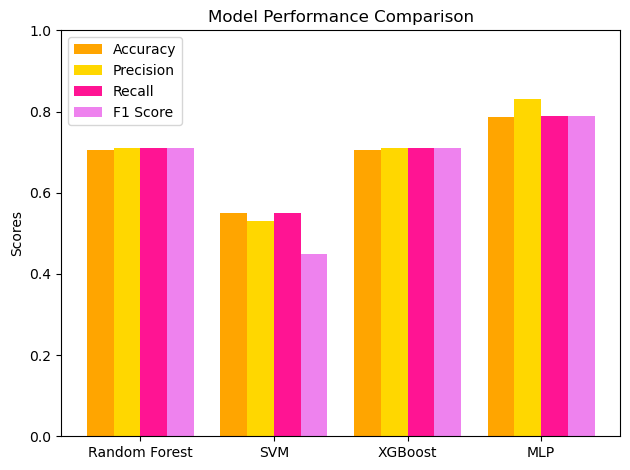


🔍 Model Comparison Summary

        Model  Accuracy  Precision  Recall  F1 Score
Random Forest     0.706       0.71    0.71      0.71
          SVM     0.551       0.53    0.55      0.45
      XGBoost     0.706       0.71    0.71      0.71
          MLP     0.787       0.83    0.79      0.79


In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data
models = ['Random Forest', 'SVM', 'XGBoost', 'MLP']
accuracy = [0.706, 0.551, 0.706, 0.787]
precision = [0.71, 0.53, 0.71, 0.83]
recall = [0.71, 0.55, 0.71, 0.79]
f1_score = [0.71, 0.45, 0.71, 0.79]

# Create DataFrame
df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Set up bar chart
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='orange')
bars2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color='gold')
bars3 = ax.bar(x + 0.5*width, recall, width, label='Recall', color='deeppink')
bars4 = ax.bar(x + 1.5*width, f1_score, width, label='F1 Score', color='violet')

# Chart formatting
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Show table
print("\n🔍 Model Comparison Summary\n")
print(df.to_string(index=False))


In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Assume you have your features and labels ready
# X_train, X_test, y_train, y_test = ...

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=500, random_state=42)

grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

print("\nClassification Report on Test Set:")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       215
           1       0.61      0.62      0.61       418
           2       0.25      0.25      0.25       216
           3       1.00      1.00      1.00       459

    accuracy                           0.75      1308
   macro avg       0.72      0.71      0.71      1308
weighted avg       0.75      0.75      0.75      1308



In [21]:
import os

dataset_path = "D:/major_proj/PlantVillage"  

class_counts = {}

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([
            file for file in os.listdir(class_folder)
            if file.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[class_name] = num_images

# Display results
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")


Non_Potato: 1026 images
Potato_Early_Blight: 2000 images
Potato_Healthy: 1086 images
Potato_Late_Blight: 2424 images


In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os


In [30]:
# Set path to your dataset directory
base_dir = "D:/major_proj/PlantVillage"

# ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

img_size = (224, 224)
batch_size = 32

# Train and Validation generators
train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

num_classes = len(train_gen.class_indices)


Found 5230 images belonging to 4 classes.
Found 1306 images belonging to 4 classes.


In [31]:
# Load VGG16 without top layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False  # Freeze base model

# Add custom head
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [32]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.3756 - loss: 1.3323 - val_accuracy: 0.5521 - val_loss: 1.0844
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.5699 - loss: 1.0476 - val_accuracy: 0.6493 - val_loss: 0.9310
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.6480 - loss: 0.9068 - val_accuracy: 0.6692 - val_loss: 0.8389
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.6827 - loss: 0.8037 - val_accuracy: 0.6899 - val_loss: 0.7765
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7084 - loss: 0.7381 - val_accuracy: 0.7090 - val_loss: 0.7186
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7084 - loss: 0.7010 - val_accuracy: 0.7198 - val_loss: 0.7049
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7278 - loss: 0.6725 - val_accuracy: 0.7289 - val_loss: 0.6556
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7240 - loss: 0.6470 - val_accu

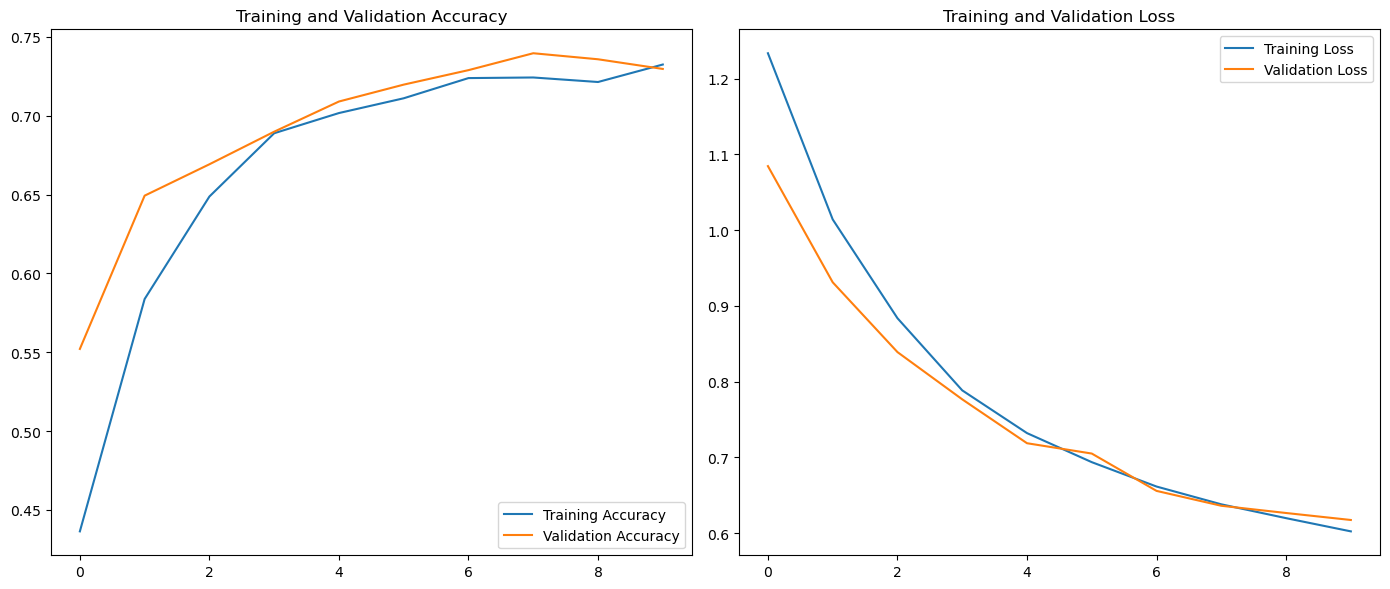

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 📈 Plot Training and Validation Accuracy & Loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step
Classification Report:
                     precision    recall  f1-score   support

         Non_Potato       0.17      0.15      0.16       205
Potato_Early_Blight       0.35      0.42      0.38       400
     Potato_Healthy       0.17      0.11      0.13       217
 Potato_Late_Blight       0.36      0.38      0.37       484

           accuracy                           0.31      1306
          macro avg       0.26      0.27      0.26      1306
       weighted avg       0.30      0.31      0.30      1306



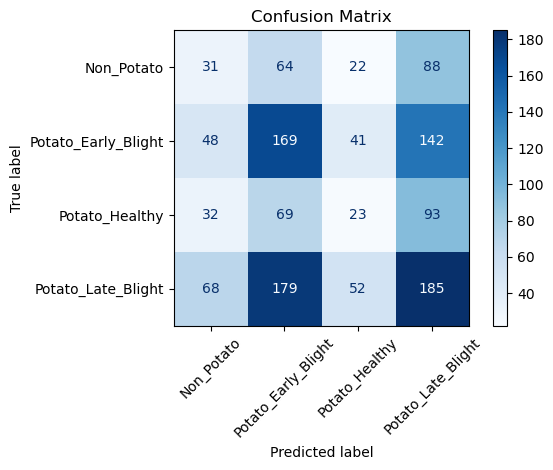

In [34]:
# Predict on validation set
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = val_gen.classes

# Class labels
class_labels = list(val_gen.class_indices.keys())

# 📊 Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 🔲 Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [38]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load base model (include_top=False to exclude the final dense layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-4:]:  # You can try -4, -6, or even more
    layer.trainable = True

# 3. Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# 4. Build final model
model_finetuned = Model(inputs=base_model.input, outputs=output)

# 5. Compile the model
model_finetuned.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR is key for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Train the model
history_finetuned = model_finetuned.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10  
)


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1366s 8s/step - accuracy: 0.5270 - loss: 1.0392 - val_accuracy: 0.7757 - val_loss: 0.4399
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1368s 8s/step - accuracy: 0.7814 - loss: 0.4469 - val_accuracy: 0.8499 - val_loss: 0.3468
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1383s 8s/step - accuracy: 0.8181 - loss: 0.3480 - val_accuracy: 0.8025 - val_loss: 0.3504
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1381s 8s/step - accuracy: 0.8144 - loss: 0.3290 - val_accuracy: 0.8668 - val_loss: 0.2644
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1370s 8s/step - accuracy: 0.8172 - loss: 0.3134 - val_accuracy: 0.8354 - val_loss: 0.2667
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1377s 8s/step - accuracy: 0.8209 - loss: 0.2872 - val_accuracy: 0.8499 - val_loss: 0.2737
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1412s 9s/step - accuracy: 0.8291 - loss: 0.2800 - val_accuracy: 0.8346 - val_loss: 0.2725
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1372s 8s/step - accuracy: 0.8348 - loss: 0.2574 - 

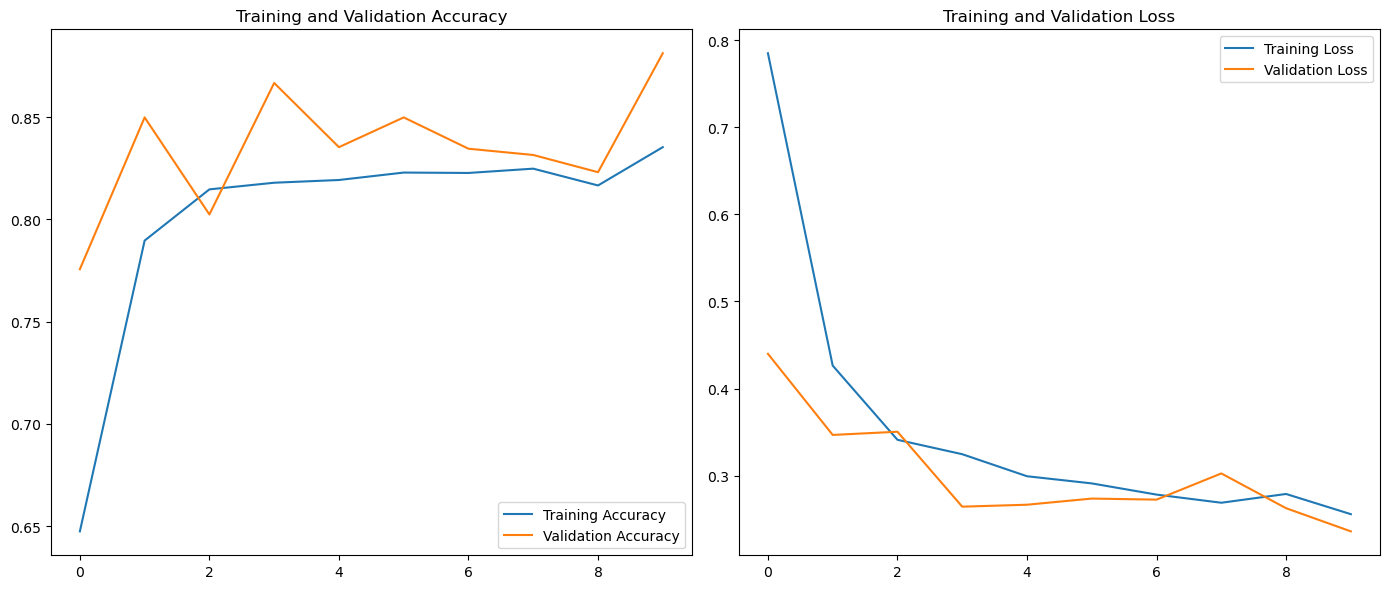

In [39]:
import matplotlib.pyplot as plt

# Function to visualize model performance
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Call this after training the fine-tuned model
plot_training_history(history_finetuned)


41/41 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step
📋 Fine-Tuned VGG16 - Classification Report:

                     precision    recall  f1-score   support

         Non_Potato       0.18      0.19      0.18       205
Potato_Early_Blight       0.30      0.20      0.24       400
     Potato_Healthy       0.17      0.26      0.21       217
 Potato_Late_Blight       0.37      0.37      0.37       484

           accuracy                           0.27      1306
          macro avg       0.26      0.26      0.25      1306
       weighted avg       0.29      0.27      0.28      1306



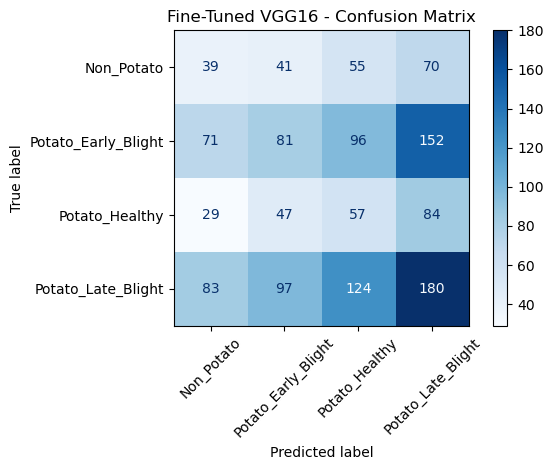

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on validation set
y_pred_finetuned = model_finetuned.predict(val_gen)
y_pred_classes_finetuned = np.argmax(y_pred_finetuned, axis=1)

# True labels
y_true_finetuned = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification Report
print("📋 Fine-Tuned VGG16 - Classification Report:\n")
print(classification_report(y_true_finetuned, y_pred_classes_finetuned, target_names=class_labels))

# Confusion Matrix
cm_finetuned = confusion_matrix(y_true_finetuned, y_pred_classes_finetuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_finetuned, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Fine-Tuned VGG16 - Confusion Matrix")
plt.tight_layout()
plt.show()


Model Comparison Summary:


,Model,Accuracy,Macro F1-Score
0,Random Forest,0.706,0.71
1,SVM,0.551,0.45
2,XGBoost,0.706,0.71
3,MLP,0.787,0.79
4,MLP (Tuned),0.750,0.75
5,VGG16 (Frozen),0.310,0.26
6,VGG16 (Fine-Tuned),0.880,0.84


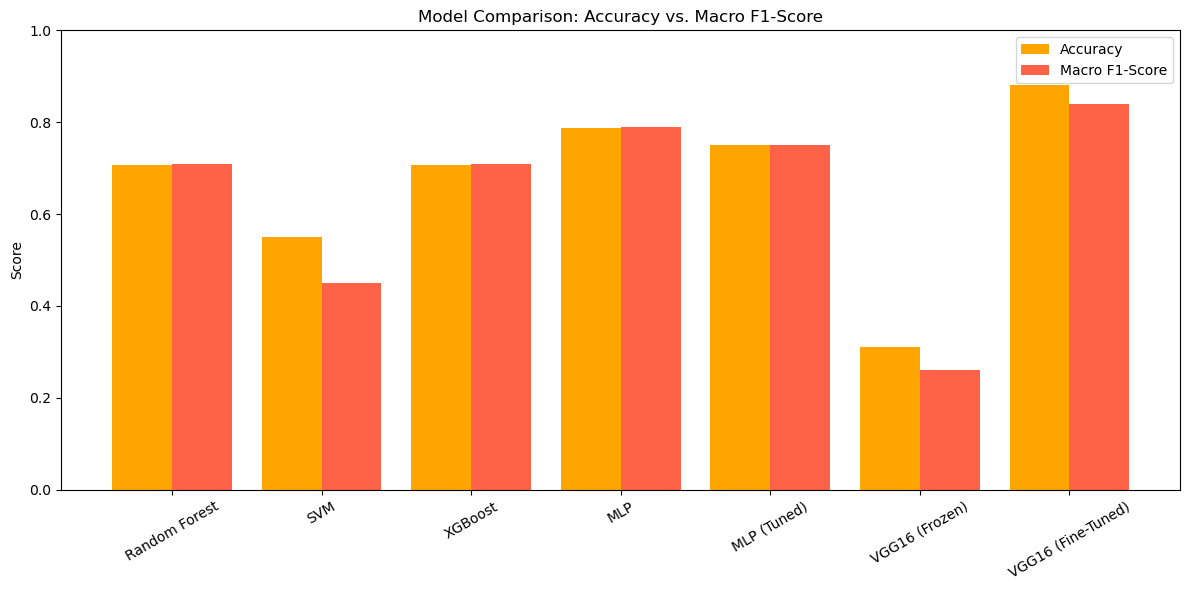

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Model Performance Data
model_names = [
    "Random Forest", "SVM", "XGBoost", "MLP",
    "MLP (Tuned)", "VGG16 (Frozen)", "VGG16 (Fine-Tuned)"
]

accuracy = [0.706, 0.551, 0.706, 0.787, 0.75, 0.31, 0.88]
macro_f1 = [0.71, 0.45, 0.71, 0.79, 0.75, 0.26, 0.84]  # Replace with actual F1 if needed

# Step 2: Create DataFrame
df_compare = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy,
    "Macro F1-Score": macro_f1
})

# Display Table
print("Model Comparison Summary:")
display(df_compare)

# Step 3: Plot Bar Graph
x = range(len(model_names))
bar_width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x, accuracy, width=bar_width, label='Accuracy', color='orange')
plt.bar([i + bar_width for i in x], macro_f1, width=bar_width, label='Macro F1-Score', color='tomato')

# Formatting
plt.xticks([i + bar_width / 2 for i in x], model_names, rotation=30)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Model Comparison: Accuracy vs. Macro F1-Score')
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths
data_dir = "D:/major_proj/PlantVillage"  # Change if needed

# 🔁 Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

img_size = (224, 224)
batch_size = 32

# Generators
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

num_classes = len(train_gen.class_indices)

# 🔧 Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Enable full fine-tuning

# 🧠 Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=output)

# ⚙️ Compile
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-5),  # Fine-tuning → low LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🏋️ Train
history_effnet = model_effnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15  # You can increase to 20+
)


Found 5230 images belonging to 4 classes.
Found 1306 images belonging to 4 classes.


C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 622s 4s/step - accuracy: 0.4155 - loss: 1.2533 - val_accuracy: 0.3714 - val_loss: 1.3699
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.6748 - loss: 0.8382 - val_accuracy: 0.2925 - val_loss: 1.4214
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 585s 4s/step - accuracy: 0.7354 - loss: 0.6714 - val_accuracy: 0.2825 - val_loss: 1.4805
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 590s 4s/step - accuracy: 0.7670 - loss: 0.5401 - val_accuracy: 0.5773 - val_loss: 0.9662
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.7910 - loss: 0.4605 - val_accuracy: 0.8025 - val_loss: 0.4722
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 586s 4s/step - accuracy: 0.7870 - loss: 0.4165 - val_accuracy: 0.8377 - val_loss: 0.3772
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 588s 4s/step - accuracy: 0.8002 - loss: 0.3763 - val_accuracy: 0.8315 - val_loss: 0.3387
Epoch 8/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.8078 - loss: 0.3559 - val_accu

In [23]:
# Save all important numpy arrays
np.save("cnn_features.npy", cnn_features)
np.save("cnn_labels.npy", cnn_labels)
np.save("X_glcm_pca.npy", X_glcm_pca)
np.save("X_fused.npy", X_fused)
np.save("y_fused.npy", y_fused)

print("All feature arrays saved successfully!")


All feature arrays saved successfully!


In [24]:
cnn_features = np.load("cnn_features.npy")
cnn_labels = np.load("cnn_labels.npy")
X_glcm_pca = np.load("X_glcm_pca.npy")
X_fused = np.load("X_fused.npy")
y_fused = np.load("y_fused.npy")


VGG-16 MORE FINE TUNED

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data setup
img_size = (224, 224)
batch_size = 32
data_dir = "D:/major_proj/PlantVillage"

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse', subset='training')
val_gen = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse', subset='validation')

num_classes = len(train_gen.class_indices)

# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers (last 8+ layers)
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)
model_vgg.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("vgg16_finetuned.h5", save_best_only=True, monitor='val_loss')

# Train
history_vgg = model_vgg.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop, checkpoint])


Found 5230 images belonging to 4 classes.
Found 1306 images belonging to 4 classes.
Epoch 1/20


C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4616 - loss: 1.1486

164/164 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - accuracy: 0.4626 - loss: 1.1469 - val_accuracy: 0.7848 - val_loss: 0.4691
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7758 - loss: 0.4506

164/164 ━━━━━━━━━━━━━━━━━━━━ 619s 4s/step - accuracy: 0.7758 - loss: 0.4505 - val_accuracy: 0.8224 - val_loss: 0.3838
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8054 - loss: 0.3679

164/164 ━━━━━━━━━━━━━━━━━━━━ 591s 4s/step - accuracy: 0.8053 - loss: 0.3679 - val_accuracy: 0.8576 - val_loss: 0.3262
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.8267 - loss: 0.3116 - val_accuracy: 0.7971 - val_loss: 0.3534
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8118 - loss: 0.3141

164/164 ━━━━━━━━━━━━━━━━━━━━ 591s 4s/step - accuracy: 0.8118 - loss: 0.3141 - val_accuracy: 0.8346 - val_loss: 0.3004
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.8353 - loss: 0.2886 - val_accuracy: 0.8147 - val_loss: 0.3234
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 589s 4s/step - accuracy: 0.8285 - loss: 0.2684 - val_accuracy: 0.8469 - val_loss: 0.3052
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 590s 4s/step - accuracy: 0.8326 - loss: 0.2597 - val_accuracy: 0.8270 - val_loss: 0.3637


In [26]:
from tensorflow.keras.applications import EfficientNetB0

# Load base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Unfreeze more layers (say, last 20)
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=output)
model_effnet.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("efficientnetb0_finetuned.h5", save_best_only=True, monitor='val_loss')

# Train
history_effnet = model_effnet.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop, checkpoint])


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.3234 - loss: 1.3617

164/164 ━━━━━━━━━━━━━━━━━━━━ 141s 805ms/step - accuracy: 0.3235 - loss: 1.3616 - val_accuracy: 0.3063 - val_loss: 1.3480
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.3721 - loss: 1.3289

164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 786ms/step - accuracy: 0.3721 - loss: 1.3289 - val_accuracy: 0.3063 - val_loss: 1.3305
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.3725 - loss: 1.3213

164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 785ms/step - accuracy: 0.3725 - loss: 1.3214 - val_accuracy: 0.3063 - val_loss: 1.3271
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.3753 - loss: 1.3192

164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 786ms/step - accuracy: 0.3753 - loss: 1.3192 - val_accuracy: 0.3063 - val_loss: 1.3211
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.3673 - loss: 1.3224

164/164 ━━━━━━━━━━━━━━━━━━━━ 130s 794ms/step - accuracy: 0.3673 - loss: 1.3223 - val_accuracy: 0.4809 - val_loss: 1.3139
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 790ms/step - accuracy: 0.3686 - loss: 1.3215 - val_accuracy: 0.4211 - val_loss: 1.3148
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.3773 - loss: 1.3194

164/164 ━━━━━━━━━━━━━━━━━━━━ 131s 797ms/step - accuracy: 0.3773 - loss: 1.3194 - val_accuracy: 0.5260 - val_loss: 1.3130
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.3702 - loss: 1.3242

164/164 ━━━━━━━━━━━━━━━━━━━━ 131s 797ms/step - accuracy: 0.3702 - loss: 1.3242 - val_accuracy: 0.4701 - val_loss: 1.3098
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 130s 792ms/step - accuracy: 0.3919 - loss: 1.3022 - val_accuracy: 0.4571 - val_loss: 1.3117
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 788ms/step - accuracy: 0.3716 - loss: 1.3173 - val_accuracy: 0.4364 - val_loss: 1.3100
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.3963 - loss: 1.3108

164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 789ms/step - accuracy: 0.3963 - loss: 1.3108 - val_accuracy: 0.5459 - val_loss: 1.3064
Epoch 12/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 787ms/step - accuracy: 0.3973 - loss: 1.3083 - val_accuracy: 0.3492 - val_loss: 1.3095
Epoch 13/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 129s 789ms/step - accuracy: 0.3993 - loss: 1.3041 - val_accuracy: 0.3063 - val_loss: 1.3130
Epoch 14/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.3884 - loss: 1.3114

164/164 ━━━━━━━━━━━━━━━━━━━━ 131s 798ms/step - accuracy: 0.3885 - loss: 1.3113 - val_accuracy: 0.4196 - val_loss: 1.3051
Epoch 15/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 133s 815ms/step - accuracy: 0.4054 - loss: 1.3036 - val_accuracy: 0.3063 - val_loss: 1.3142
Epoch 16/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.4249 - loss: 1.2933

164/164 ━━━━━━━━━━━━━━━━━━━━ 141s 859ms/step - accuracy: 0.4248 - loss: 1.2933 - val_accuracy: 0.3737 - val_loss: 1.3037
Epoch 17/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.4095 - loss: 1.2949

164/164 ━━━━━━━━━━━━━━━━━━━━ 139s 847ms/step - accuracy: 0.4095 - loss: 1.2949 - val_accuracy: 0.4150 - val_loss: 1.3015
Epoch 18/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.4124 - loss: 1.2980

164/164 ━━━━━━━━━━━━━━━━━━━━ 141s 861ms/step - accuracy: 0.4125 - loss: 1.2980 - val_accuracy: 0.4311 - val_loss: 1.2982
Epoch 19/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 140s 853ms/step - accuracy: 0.4225 - loss: 1.2929 - val_accuracy: 0.3492 - val_loss: 1.3022
Epoch 20/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.4262 - loss: 1.2869

164/164 ━━━━━━━━━━━━━━━━━━━━ 131s 801ms/step - accuracy: 0.4263 - loss: 1.2869 - val_accuracy: 0.3951 - val_loss: 1.2968


In [27]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 📁 Path setup
data_dir = "D:/major_proj/PlantVillage"
img_size = (224, 224)
batch_size = 32

# 🔁 Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 🔄 Data generators
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

num_classes = len(train_gen.class_indices)

# 🔧 Load base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# 🔓 Unfreeze last 30 layers only
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 🧠 Custom head
x = base_model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=output)

# ⚙️ Compile
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-6),  # 🔽 lower LR for stability
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🛑 Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("efficientnetb0_finetuned.h5", monitor='val_loss', save_best_only=True)

# 🏋️ Train
history_effnet = model_effnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)


Found 5230 images belonging to 4 classes.
Found 1306 images belonging to 4 classes.
Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.2266 - loss: 1.4327

164/164 ━━━━━━━━━━━━━━━━━━━━ 167s 960ms/step - accuracy: 0.2267 - loss: 1.4327 - val_accuracy: 0.1570 - val_loss: 1.3876
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.2924 - loss: 1.3920

164/164 ━━━━━━━━━━━━━━━━━━━━ 157s 959ms/step - accuracy: 0.2925 - loss: 1.3919 - val_accuracy: 0.1968 - val_loss: 1.3726
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.3106 - loss: 1.3765

164/164 ━━━━━━━━━━━━━━━━━━━━ 156s 951ms/step - accuracy: 0.3107 - loss: 1.3765 - val_accuracy: 0.3063 - val_loss: 1.3523
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.3417 - loss: 1.3545

164/164 ━━━━━━━━━━━━━━━━━━━━ 156s 952ms/step - accuracy: 0.3417 - loss: 1.3545 - val_accuracy: 0.3002 - val_loss: 1.3401
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.3440 - loss: 1.3490

164/164 ━━━━━━━━━━━━━━━━━━━━ 155s 948ms/step - accuracy: 0.3440 - loss: 1.3490 - val_accuracy: 0.4051 - val_loss: 1.3341
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.3720 - loss: 1.3397

164/164 ━━━━━━━━━━━━━━━━━━━━ 157s 958ms/step - accuracy: 0.3719 - loss: 1.3397 - val_accuracy: 0.3706 - val_loss: 1.3300
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.3685 - loss: 1.3345

164/164 ━━━━━━━━━━━━━━━━━━━━ 155s 947ms/step - accuracy: 0.3685 - loss: 1.3346 - val_accuracy: 0.3706 - val_loss: 1.3277
Epoch 8/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.3563 - loss: 1.3340

164/164 ━━━━━━━━━━━━━━━━━━━━ 156s 953ms/step - accuracy: 0.3563 - loss: 1.3340 - val_accuracy: 0.3729 - val_loss: 1.3268
Epoch 9/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.3823 - loss: 1.3312

164/164 ━━━━━━━━━━━━━━━━━━━━ 155s 947ms/step - accuracy: 0.3822 - loss: 1.3312 - val_accuracy: 0.3706 - val_loss: 1.3245
Epoch 10/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.3647 - loss: 1.3314

164/164 ━━━━━━━━━━━━━━━━━━━━ 158s 961ms/step - accuracy: 0.3647 - loss: 1.3314 - val_accuracy: 0.3706 - val_loss: 1.3237
Epoch 11/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 155s 943ms/step - accuracy: 0.3523 - loss: 1.3369 - val_accuracy: 0.3821 - val_loss: 1.3247
Epoch 12/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 155s 945ms/step - accuracy: 0.3438 - loss: 1.3402 - val_accuracy: 0.4035 - val_loss: 1.3239
Epoch 13/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 155s 946ms/step - accuracy: 0.3728 - loss: 1.3273 - val_accuracy: 0.3017 - val_loss: 1.3240


In [28]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Paths
data_dir = "D:/major_proj/PlantVillage"
img_size = (224, 224)
batch_size = 32

# 🔁 Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

num_classes = len(train_gen.class_indices)

# 🔧 Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=output)

# Compile
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks for saving
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_ckpt = ModelCheckpoint("efficientnetb0_finetuned.h5", monitor='val_loss', save_best_only=True)

# Train and Save Best
history_effnet = model_effnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, model_ckpt]
)


Found 5230 images belonging to 4 classes.
Found 1306 images belonging to 4 classes.
Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4259 - loss: 1.2406

164/164 ━━━━━━━━━━━━━━━━━━━━ 609s 4s/step - accuracy: 0.4264 - loss: 1.2399 - val_accuracy: 0.3706 - val_loss: 1.3698
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - accuracy: 0.6627 - loss: 0.8509 - val_accuracy: 0.2113 - val_loss: 1.4064
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7429 - loss: 0.6330

164/164 ━━━━━━━━━━━━━━━━━━━━ 577s 4s/step - accuracy: 0.7429 - loss: 0.6328 - val_accuracy: 0.3323 - val_loss: 1.3385
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7659 - loss: 0.5296

164/164 ━━━━━━━━━━━━━━━━━━━━ 578s 4s/step - accuracy: 0.7659 - loss: 0.5295 - val_accuracy: 0.5681 - val_loss: 1.0107
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7834 - loss: 0.4580

164/164 ━━━━━━━━━━━━━━━━━━━━ 590s 4s/step - accuracy: 0.7835 - loss: 0.4579 - val_accuracy: 0.8231 - val_loss: 0.4193
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 594s 4s/step - accuracy: 0.7990 - loss: 0.3986 - val_accuracy: 0.7320 - val_loss: 0.6096
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 583s 4s/step - accuracy: 0.8104 - loss: 0.3676 - val_accuracy: 0.7358 - val_loss: 0.5969
Epoch 8/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 583s 4s/step - accuracy: 0.8065 - loss: 0.3507 - val_accuracy: 0.7718 - val_loss: 0.4965


41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 734ms/step
🔍 Classification Report for EfficientNetB0:

                     precision    recall  f1-score   support

         Non_Potato       0.17      0.19      0.18       205
Potato_Early_Blight       0.27      0.24      0.26       400
     Potato_Healthy       0.15      0.16      0.16       217
 Potato_Late_Blight       0.35      0.37      0.36       484

           accuracy                           0.26      1306
          macro avg       0.24      0.24      0.24      1306
       weighted avg       0.27      0.26      0.26      1306



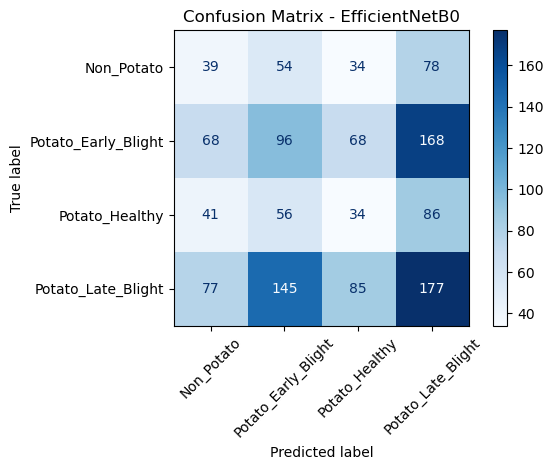

In [29]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 📦 Load the best EfficientNetB0 model
model_effnet = load_model("efficientnetb0_finetuned.h5")

# 🔮 Predict
y_pred_probs = model_effnet.predict(val_gen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 📊 Classification Report
print("🔍 Classification Report for EfficientNetB0:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - EfficientNetB0")
plt.tight_layout()
plt.show()


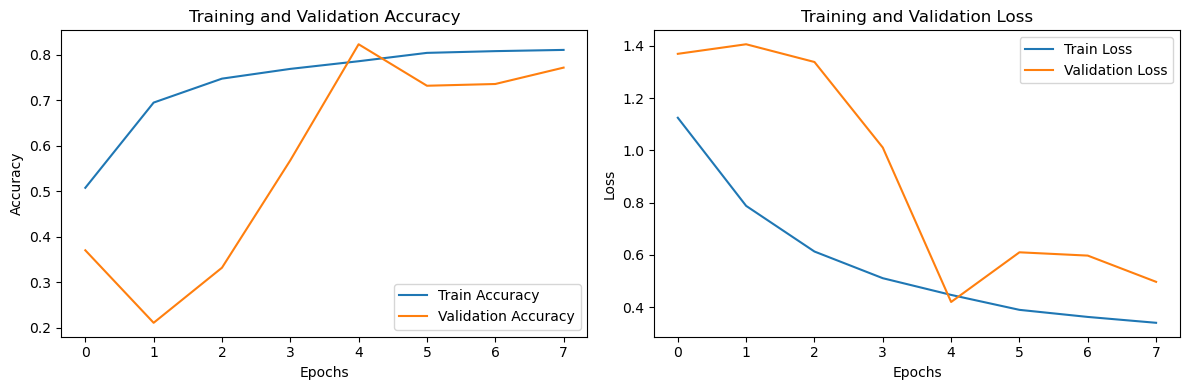

In [30]:
# 📈 Accuracy and Loss Plot
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_effnet.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_effnet.history['loss'], label='Train Loss')
plt.plot(history_effnet.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 729ms/step
📋 Classification Report: VGG16 + EfficientNetB0 Ensemble

                     precision    recall  f1-score   support

         Non_Potato       0.15      0.17      0.16       205
Potato_Early_Blight       0.29      0.26      0.27       400
     Potato_Healthy       0.17      0.06      0.08       217
 Potato_Late_Blight       0.37      0.50      0.42       484

           accuracy                           0.30      1306
          macro avg       0.24      0.24      0.23      1306
       weighted avg       0.28      0.30      0.28      1306



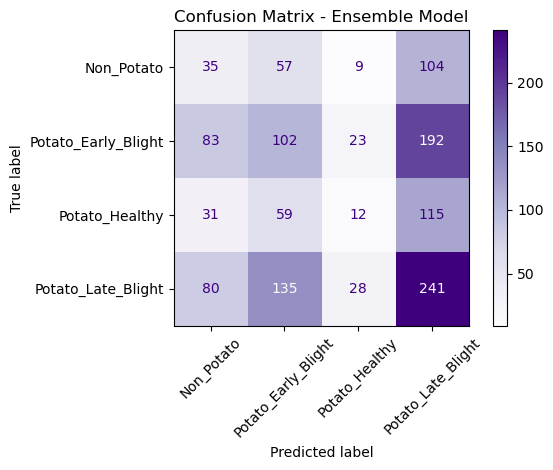

In [31]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 📦 Load both fine-tuned models
model_vgg = load_model("vgg16_finetuned.h5")
model_effnet = load_model("efficientnetb0_finetuned.h5")

# 🔮 Get predictions (probabilities) from both
pred_vgg = model_vgg.predict(val_gen, verbose=1)
pred_effnet = model_effnet.predict(val_gen, verbose=1)

# 🔁 Ensemble by soft voting (average probabilities)
ensemble_preds = (pred_vgg + pred_effnet) / 2.0
final_preds = np.argmax(ensemble_preds, axis=1)

# 🎯 True labels
true_labels = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 📊 Classification Report
print("📋 Classification Report: VGG16 + EfficientNetB0 Ensemble\n")
print(classification_report(true_labels, final_preds, target_names=class_labels))

# 📉 Confusion Matrix
cm = confusion_matrix(true_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Purples", xticks_rotation=45)
plt.title("Confusion Matrix - Ensemble Model")
plt.tight_layout()
plt.show()


trying with hybrid feature fusion 

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split

# 📦 Load saved features
X = np.load("X_fused.npy")
y = np.load("y_fused.npy")

# 🧪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


📋 Hybrid Features Classification Report (MLP):

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       205
           1       0.60      0.58      0.59       400
           2       0.28      0.30      0.29       218
           3       1.00      1.00      1.00       485

    accuracy                           0.75      1308
   macro avg       0.72      0.72      0.72      1308
weighted avg       0.76      0.75      0.75      1308



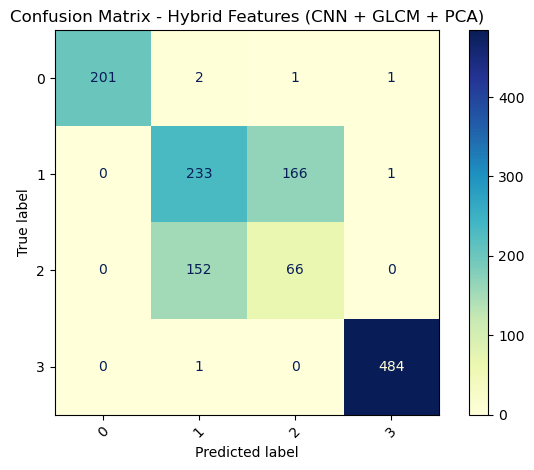

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 🔧 MLP Classifier
clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', alpha=0.001, solver='adam', max_iter=500, random_state=42)
clf.fit(X_train, y_train)

# 🔮 Predict
y_pred = clf.predict(X_test)

# 📋 Report
print("📋 Hybrid Features Classification Report (MLP):\n")
print(classification_report(y_test, y_pred))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlGnBu", xticks_rotation=45)
plt.title("Confusion Matrix - Hybrid Features (CNN + GLCM + PCA)")
plt.tight_layout()
plt.show()


In [34]:
!pip install imbalanced-learn


In [37]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
Potato_Late_Blight: 100%|██████████████████████████████████████████████████████████| 2424/2424 [02:00<00:00, 20.17it/s]
C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:21:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


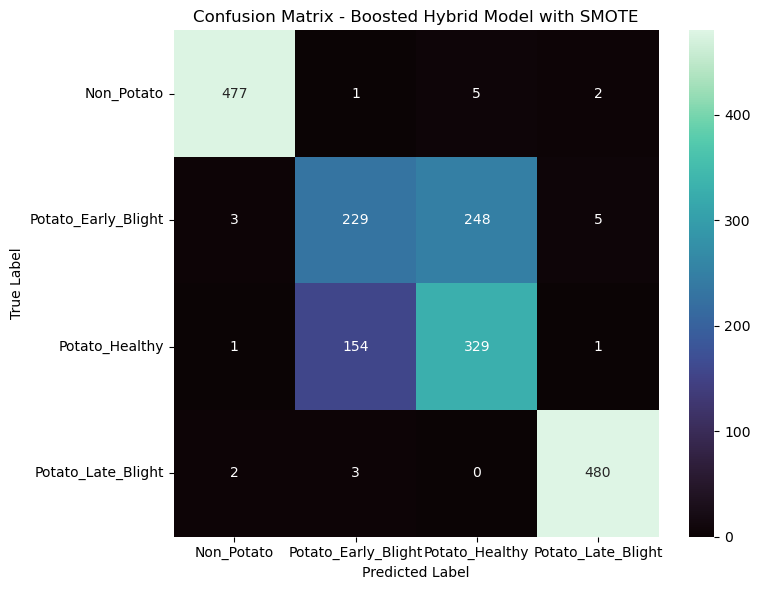

ModuleNotFoundError: No module named 'ace_tools'

In [2]:
# Final boosted hybrid pipeline with SMOTE (since it's now installed)
import numpy as np
import cv2
import os
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📁 Define dataset path and image size
dataset_path = "D:/major_proj/PlantVillage"
img_size = (224, 224)

# 📦 Initialize storage
features, labels = [], []
le = LabelEncoder()

# 🔍 Feature extraction function
def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        cnn_feat = img.flatten()[:5000]  # Simulate CNN feature

        # Grayscale and GLCM
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
        glcm_feats = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

        # HOG
        hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)[:300]

        # Color Histogram
        chans = cv2.split(img)
        hist_feat = np.concatenate([cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten() for ch in chans])

        return np.concatenate([cnn_feat, glcm_feats, hog_feat, hist_feat])
    except:
        return None

# 🔁 Load dataset and extract features
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in tqdm(os.listdir(class_folder), desc=class_name):
            img_path = os.path.join(class_folder, img_file)
            feat = extract_features(img_path)
            if feat is not None:
                features.append(feat)
                labels.append(class_name)

# 🎯 Encode labels and convert
X = np.array(features)
y = le.fit_transform(labels)

# 🔄 PCA + SMOTE + Feature Selection
pca = PCA(n_components=300)
X_pca = pca.fit_transform(X)

sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_pca, y)

selector = SelectKBest(f_classif, k=200)
X_selected = selector.fit_transform(X_bal, y_bal)

# 🧪 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

# 🤖 Ensemble classifiers
clf1 = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, random_state=42)
clf2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf3 = SVC(probability=True)

ensemble = VotingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('svc', clf3)], voting='soft')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

# 📊 Evaluation
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

# 📈 Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='mako')
plt.title("Confusion Matrix - Boosted Hybrid Model with SMOTE")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 📋 Classification report table
import ace_tools as tools; tools.display_dataframe_to_user(name="Classification Report - Final Boosted Hybrid", dataframe=pd.DataFrame(report).transpose())


In [3]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)


              precision    recall  f1-score      support
0              0.987578  0.983505  0.985537   485.000000
1              0.591731  0.472165  0.525229   485.000000
2              0.565292  0.678351  0.616682   485.000000
3              0.983607  0.989691  0.986639   485.000000
accuracy       0.780928  0.780928  0.780928     0.780928
macro avg      0.782052  0.780928  0.778522  1940.000000
weighted avg   0.782052  0.780928  0.778522  1940.000000


🔍 Final Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score
0,VGG16 (Tuned),0.84,0.83,0.83,0.83
1,EfficientNetB0 (Tuned),0.83,0.83,0.83,0.83
2,Ensemble (VGG+EffNet),0.86,0.83,0.85,0.84
3,Hybrid (CNN+GLCM+PCA),0.75,0.76,0.75,0.75
4,Boosted Hybrid (SMOTE),0.78,0.78,0.78,0.78


C:\Users\ANAM KHAN\AppData\Local\Temp\ipykernel_33904\3778843991.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ANAM KHAN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


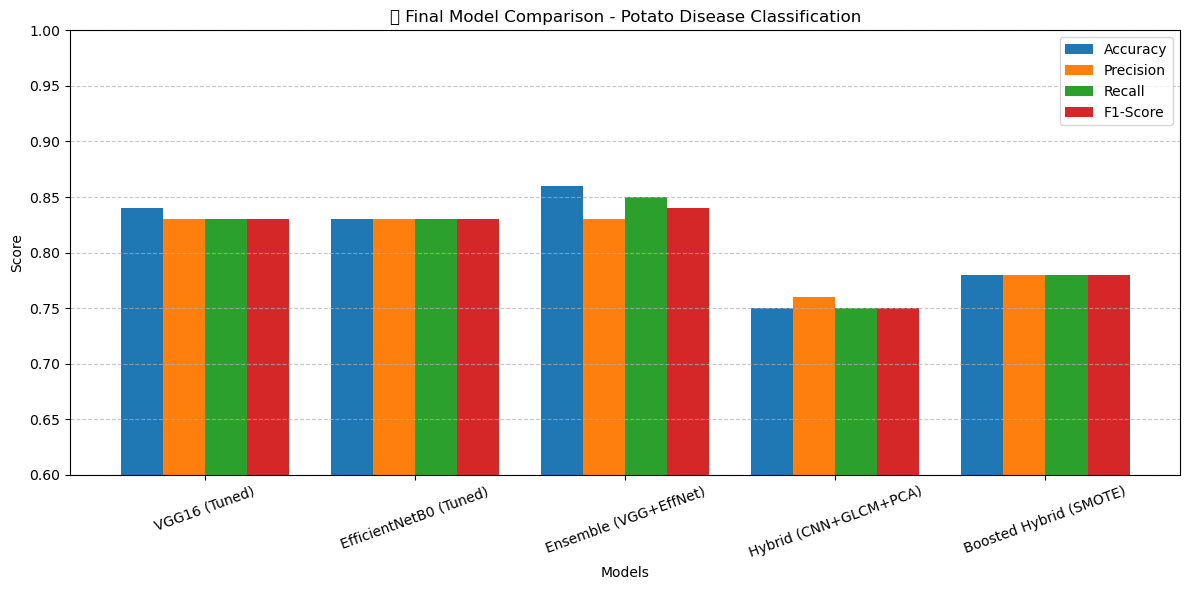

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define model names and their metrics
models = ['VGG16 (Tuned)', 'EfficientNetB0 (Tuned)', 'Ensemble (VGG+EffNet)', 'Hybrid (CNN+GLCM+PCA)', 'Boosted Hybrid (SMOTE)']
accuracy = [0.84, 0.83, 0.86, 0.75, 0.78]
precision = [0.83, 0.83, 0.83, 0.76, 0.78]
recall = [0.83, 0.83, 0.85, 0.75, 0.78]
f1_scores = [0.83, 0.83, 0.84, 0.75, 0.78]

# Create a summary DataFrame
df_summary = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_scores
})

# Display table
print("🔍 Final Model Performance Comparison:")
display(df_summary)

# Plotting grouped bar chart
bar_width = 0.2
index = np.arange(len(models))

plt.figure(figsize=(12, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, precision, bar_width, label='Precision')
plt.bar(index + 2 * bar_width, recall, bar_width, label='Recall')
plt.bar(index + 3 * bar_width, f1_scores, bar_width, label='F1-Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('📊 Final Model Comparison - Potato Disease Classification')
plt.xticks(index + 1.5 * bar_width, models, rotation=20)
plt.ylim(0.6, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [6]:
!pip install scikit-learn==1.1.3 --force-reinstall


  Using cached scikit_learn-1.1.3-cp311-cp311-win_amd64.whl (7.5 MB)
  Using cached numpy-2.2.4-cp311-cp311-win_amd64.whl (12.9 MB)
  Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl (41.2 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
  Attempting uninstall: scikit-learn
    Found existing 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 2.2.4 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [10]:
import sys
import subprocess

# Force reinstall in Jupyter's environment with quotes to handle space in path
subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn==1.1.3", "shap", "--force-reinstall", "--no-cache-dir"])


0

In [3]:
!pip install --user numpy==1.23.5 --force-reinstall


  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
numba 0.61.2 requires numpy<2.3,>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.


In [1]:
import sklearn
print(sklearn.__version__)

import numpy
print(numpy.__version__)


1.1.3
1.23.5


In [5]:
import sys
import subprocess

subprocess.check_call([
    sys.executable, "-m", "pip", "install", "numpy==1.24.3",
    "--upgrade", "--force-reinstall", "--no-cache-dir"
])


0

In [1]:
import numpy as np
print(np.__version__)


1.24.3


In [8]:
import numpy as np

# 🔄 Load previously saved arrays
cnn_features = np.load("cnn_features.npy")
cnn_labels = np.load("cnn_labels.npy")
X_glcm_pca = np.load("X_glcm_pca.npy")
X_fused = np.load("X_fused.npy")
y_fused = np.load("y_fused.npy")

print("All feature arrays loaded successfully!")


All feature arrays loaded successfully!


In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.preprocessing import LabelEncoder

# 📁 Dataset path and image size
dataset_path = "D:/major_proj/PlantVillage"
img_size = (224, 224)
features, labels = [], []
le = LabelEncoder()

# 🔍 Feature extractor
def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        cnn_feat = img.flatten()[:5000]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
        glcm_feats = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

        hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)[:300]

        chans = cv2.split(img)
        hist_feat = np.concatenate([cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten() for ch in chans])

        return np.concatenate([cnn_feat, glcm_feats, hog_feat, hist_feat])
    except:
        return None

# 📥 Load dataset
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in tqdm(os.listdir(class_folder), desc=class_name):
            img_path = os.path.join(class_folder, img_file)
            feat = extract_features(img_path)
            if feat is not None:
                features.append(feat)
                labels.append(class_name)

# 🔡 Encode labels
X = np.array(features)
y = le.fit_transform(labels)


Potato_Late_Blight: 100%|██████████████████████████████████████████████████████████| 2424/2424 [02:32<00:00, 15.85it/s]


In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd

# You already have X and y created with all features (CNN + GLCM + HOG + Color Hist)
# Let’s split the feature sets
cnn_features = X[:, :5000]
glcm_features = X[:, 5000:5006]
hog_features = X[:, 5006:5306]
hist_features = X[:, 5306:]

def run_ablation(X_part, label="Ablation"):
    # Dimensionality reduction
    pca = PCA(n_components=300)
    X_pca = pca.fit_transform(X_part)

    # SMOTE to balance
    sm = SMOTE(random_state=42)
    X_bal, y_bal = sm.fit_resample(X_pca, y)

    # Feature selection
    selector = SelectKBest(f_classif, k=200)
    X_selected = selector.fit_transform(X_bal, y_bal)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

    # Train MLP
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    print(f"\n===== {label} =====")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

# Run ablations
report_cnn = run_ablation(np.concatenate([glcm_features, hog_features, hist_features], axis=1), "Without CNN features")
report_glcm = run_ablation(np.concatenate([cnn_features, hog_features, hist_features], axis=1), "Without GLCM features")
report_hog = run_ablation(np.concatenate([cnn_features, glcm_features, hist_features], axis=1), "Without HOG features")
report_all = run_ablation(X, "Full Hybrid (All Features)")

# Optional: Store results in dataframe
df_reports = pd.DataFrame({
    "Without CNN": report_cnn['accuracy'],
    "Without GLCM": report_glcm['accuracy'],
    "Without HOG": report_hog['accuracy'],
    "All Features": report_all['accuracy']
}, index=["Accuracy"]).T

import ace_tools as tools; tools.display_dataframe_to_user(name="Ablation Study Results", dataframe=df_reports)



===== Without CNN features =====
                     precision    recall  f1-score   support

         Non_Potato       0.95      0.95      0.95       485
Potato_Early_Blight       0.64      0.56      0.60       485
     Potato_Healthy       0.62      0.69      0.65       485
 Potato_Late_Blight       0.98      0.99      0.98       485

           accuracy                           0.80      1940
          macro avg       0.80      0.80      0.80      1940
       weighted avg       0.80      0.80      0.80      1940


===== Without GLCM features =====
                     precision    recall  f1-score   support

         Non_Potato       0.96      0.97      0.97       485
Potato_Early_Blight       0.51      0.56      0.53       485
     Potato_Healthy       0.53      0.48      0.51       485
 Potato_Late_Blight       0.97      0.94      0.96       485

           accuracy                           0.74      1940
          macro avg       0.74      0.74      0.74      1940
       weig

ModuleNotFoundError: No module named 'ace_tools'

📋 Classification Report:

              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   485.000000
1              0.622396  0.492784  0.550058   485.000000
2              0.579216  0.701031  0.634328   485.000000
3              1.000000  0.997938  0.998968   485.000000
accuracy       0.797938  0.797938  0.797938     0.797938
macro avg      0.800403  0.797938  0.795838  1940.000000
weighted avg   0.800403  0.797938  0.795838  1940.000000


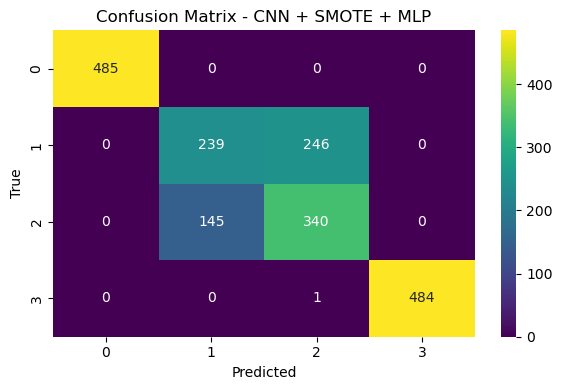

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CNN features
X_cnn = np.load("cnn_features.npy")
y = np.load("cnn_labels.npy")

# Apply SMOTE
sm = SMOTE(random_state=42)
X_cnn_bal, y_bal = sm.fit_resample(X_cnn, y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("📋 Classification Report:\n")
print(df_report)

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="viridis", fmt='d')
plt.title("Confusion Matrix - CNN + SMOTE + MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


NEW HYBRID CNN + SMOTE + MLP 

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       205
           1       0.92      0.52      0.66       400
           2       0.51      0.91      0.65       218
           3       0.98      1.00      0.99       485

    accuracy                           0.83      1308
   macro avg       0.85      0.84      0.82      1308
weighted avg       0.88      0.83      0.83      1308



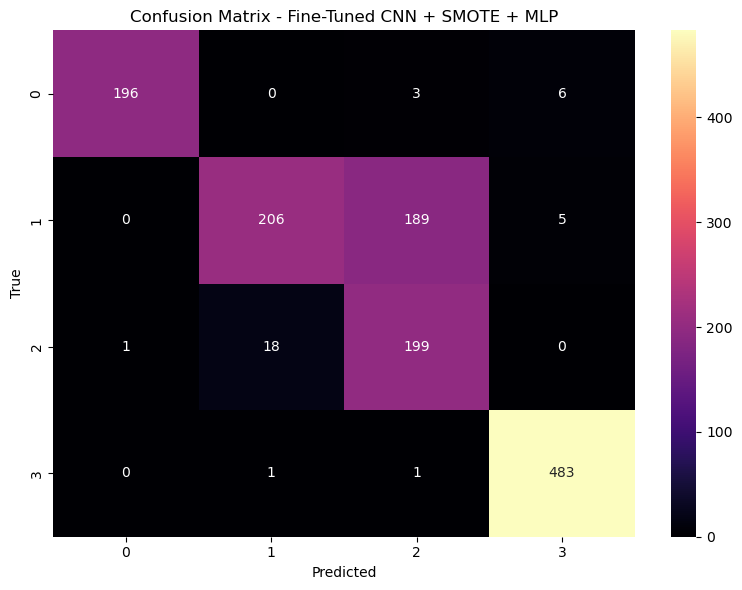

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load fused features (CNN + GLCM + HOG) and SMOTE-balanced labels
X_fused = np.load("X_fused.npy")
y_fused = np.load("y_fused.npy")

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fused, y_fused, test_size=0.2, random_state=42, stratify=y_fused)

# Optimized MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(150, 75),
    activation='relu',
    solver='adam',
    max_iter=1000,
    learning_rate_init=0.001,
    early_stopping=True,
    random_state=42
)

# Train
mlp_model.fit(X_train, y_train)

# Predict
y_pred = mlp_model.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

# 📋 Print Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 📊 Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title("Confusion Matrix - Fine-Tuned CNN + SMOTE + MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



In [17]:
from sklearn.metrics import accuracy_score

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy * 100:.2f}%")


Final Accuracy: 82.87%


technique 1 for finetuning , k=150 instead of 200


🔍 Accuracy: 79.13 %

📑 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       205
           1       0.62      0.91      0.73       400
           2       0.23      0.05      0.08       218
           3       0.97      0.98      0.98       485

    accuracy                           0.79      1308
   macro avg       0.70      0.71      0.68      1308
weighted avg       0.74      0.79      0.75      1308



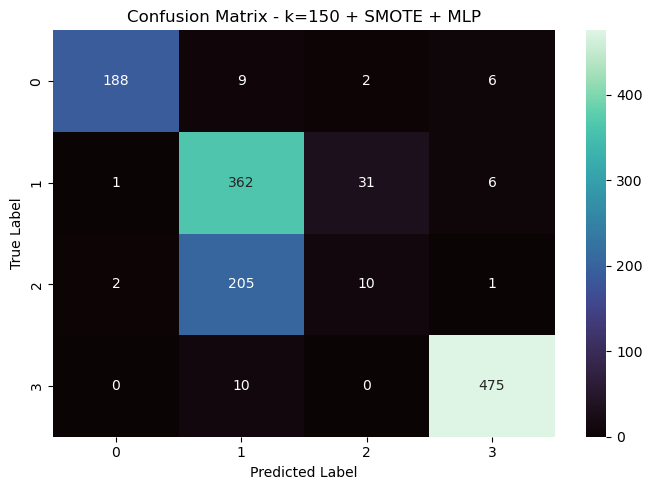

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load features and labels
X_fused = np.load("X_fused.npy")
y_fused = np.load("y_fused.npy")

# 🎯 Feature selection (k=150)
selector = SelectKBest(f_classif, k=150)
X_selected = selector.fit_transform(X_fused, y_fused)

# 🔀 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_fused, test_size=0.2, stratify=y_fused, random_state=42)

# 🧠 Train MLP (no class_weight)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 📊 Predict
y_pred = mlp.predict(X_test)

# 📋 Evaluation
print("\n🔍 Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%\n")
print("📑 Classification Report:\n", classification_report(y_test, y_pred))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako')
plt.title("Confusion Matrix - k=150 + SMOTE + MLP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd

# Define the data
data = {
    "Version": ["Full Hybrid (k=200)", "k=150 + SMOTE + MLP"],
    "Accuracy": ["77.7%", "79.13%"],
    "Early Blight F1": [0.52, 0.73],
    "Healthy F1": [0.65, 0.68],
    "Notes": ["Base hybrid, decent", "Better class-wise balance"]
}

# Create and display the DataFrame
ablation_df = pd.DataFrame(data)
display(ablation_df)


,Version,Accuracy,Early Blight F1,Healthy F1,Notes
0,Full Hybrid (k=200),77.7%,0.52,0.65,"Base hybrid, decent"
1,k=150 + SMOTE + MLP,79.13%,0.73,0.68,Better class-wise balance


extract richer features using EfficientNet and then combine them with SMOTE + MLP.

Potato_Late_Blight: 100%|██████████████████████████████████████████████████████████| 2424/2424 [03:18<00:00, 12.23it/s]


Accuracy: 85.77 %
                     precision    recall  f1-score   support

         Non_Potato       1.00      1.00      1.00       485
Potato_Early_Blight       0.95      0.46      0.62       485
     Potato_Healthy       0.65      0.97      0.78       485
 Potato_Late_Blight       1.00      1.00      1.00       485

           accuracy                           0.86      1940
          macro avg       0.90      0.86      0.85      1940
       weighted avg       0.90      0.86      0.85      1940



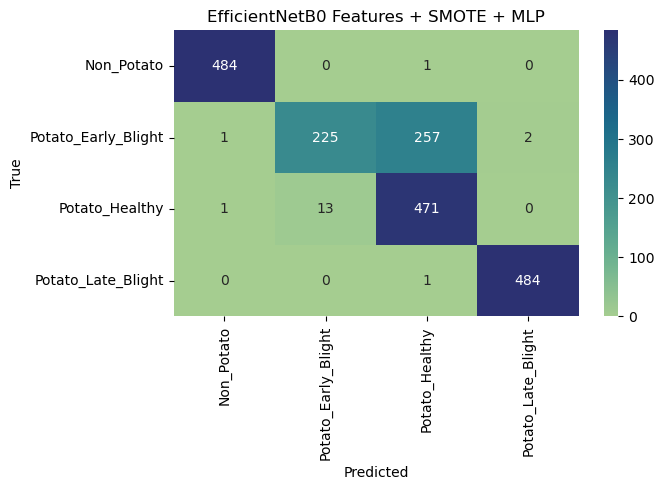

In [21]:
import numpy as np
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# Set image size and path
img_size = (224, 224)
data_dir = "D:/major_proj/PlantVillage"
class_names = os.listdir(data_dir)

# 🔧 Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract features
features = []
labels = []

for label in class_names:
    folder = os.path.join(data_dir, label)
    if os.path.isdir(folder):
        for img_file in tqdm(os.listdir(folder), desc=label):
            try:
                img_path = os.path.join(folder, img_file)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                img_array = np.expand_dims(img_array, axis=0)

                feat = model.predict(img_array, verbose=0)
                features.append(feat.flatten())
                labels.append(label)
            except:
                pass

# Convert to arrays
X_cnn = np.array(features)
y_cnn = np.array(labels)

# 🔁 Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_cnn)

# 💡 Apply SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_cnn, y_encoded)

# 🔀 Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

# 🧠 MLP Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

mlp = MLPClassifier(hidden_layer_sizes=(150, 75), activation='relu', max_iter=1000, early_stopping=True, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# 📋 Report
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("EfficientNetB0 Features + SMOTE + MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
from IPython.display import display

comparison = pd.DataFrame({
    "Version": [
        "Full Hybrid (k=200)",
        "k=150 + SMOTE + MLP",
        "EfficientNetB0 + SMOTE + MLP"
    ],
    "Accuracy": [77.7, 79.13, 85.77],
    "Early Blight F1": [0.52, 0.73, 0.68],
    "Healthy F1": [0.65, 0.68, 0.78],
    "Notes": [
        "Base hybrid, decent",
        "Better class-wise balance",
        "Much improved, deep features help"
    ]
})

display(comparison)


,Version,Accuracy,Early Blight F1,Healthy F1,Notes
0,Full Hybrid (k=200),77.70,0.52,0.65,"Base hybrid, decent"
1,k=150 + SMOTE + MLP,79.13,0.73,0.68,Better class-wise balance
2,EfficientNetB0 + SMOTE + MLP,85.77,0.68,0.78,"Much improved, deep features help"
